# Real NVP Normalizing Flows implementation

This code aims to implement Real NVP models, along with a function to optimize the model directly given a set of data.

### RNVP model
We begin by implementing the model as outlined in _Introduction to Normalizing Flows_ by Ullrich Köthe, as can be found [in these slides](https://indico.desy.de/event/28296/contributions/98231/attachments/64547/79399/INNs-Terascale-March-2021.pdf).

The model is also inspired from [this notebook](https://colab.research.google.com/github/senya-ashukha/real-nvp-pytorch/blob/master/real-nvp-pytorch.ipynb#scrollTo=zd-is0myY99O)

In [38]:
# necessary imports
import torch
from torch import nn
from torch import distributions

from sklearn import datasets

from tqdm._tqdm_notebook import trange

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300


class RealNVP(nn.Module):
    def __init__(self, nets: nn.Sequential, 
                 nett: nn.Sequential, mask: torch.Tensor, 
                 base_dist: torch.distributions.Distribution):
        """Initializes the model for a Normalizing Flow

        Args:
            nets (nn.Sequential): Neural Network model used to describe the 
            scaling 's' used in each layer of the coupling flow
            
            nett (nn.Sequential): Neural Network model used to describe the 
            shifts 't' used in each layer of the coupling flow
            
            mask (torch.Tensor): Tensors of shape: (layer, dim) only containing '1's and '0's
            Used to 'mask' different components of the vector in each layer
            
            base_dist (torch.distributions.Distribution): The base distribution for z
            (usually taken to be a Multivariable normal distribution)

        """
        super(RealNVP, self).__init__()
        self.base_dist = base_dist
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(mask))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(mask))])
        return None


    def f(self, x: torch.Tensor) -> tuple:
        """Apply the sequence of functions in the RNVP model

        Args:
            x (torch.Tensor): Input vector to which the flow is applied
            shape of 'x': (dim)

        Returns:
            (torch.Tensor, torch.Tensor): Return the value of the input after being
            evaluated by the normalizing flow, along with the log determinant of the jacobian
        """
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    

    def f_inv(self, z: torch.Tensor) -> torch.Tensor:
        """Applies the inverse of the normalizing flow to 'z'

        Args:
            z (torch.Tensor): Vector of dimension (dim)

        Returns:
            torch.Tensor: Return the value of z after being evaluated by the 
            inverse of the normalizing flow
        """
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x


    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        """Returns the log likelihood

        Args:
            x (torch.Tensor): Input tensor to evaluate the log likelihood for

        Returns:
            torch.Tensor: Torch scalar representing the log of the likelihood of x
        """
        z, logp = self.f(x)
        return self.base_dist.log_prob(z) + logp


    def sample(self, batchSize: int) -> torch.Tensor:
        """Returns samples from the approximated

        Args:
            batchSize (int): Number of samples to be returned

        Returns:
            torch.Tensor: Tensor with all the samples. Has shape: (batchSize, 0, dim)
            Needs to be accessed with an extra 0 
            
        Example:
            samples = model.sample(batchSize).detach().numpy()
            plt.scatter(samples[:, 0, 0], samples[:, 0, 1])
        """ 
        z = self.base_dist.sample((batchSize, 1))
        x = self.f_inv(z)
        return x

### Optimizing function
We proceed to construct a function which returns an optimized model, which takes as an input a set of data and hyperparameters. If different sequentials are desired for `t` and `s`, then they need to be modified inside this function.

In [64]:
def create_flow(dim: int, layers: int, base_dist: distributions.Distribution,
                data: torch.Tensor, **hyperparams) -> RealNVP:
    """Creates an optimized flow given a set of data, the dimensions
        of the data, and a number of layers

    Args:
        dim (int): The dimension of each data point
        layers (int): Number of layers in the network defining 't' and 's'
        base_dist (distributions.Distribution): The base_distribution for the RNVP model
        data (torch.Tensor): Set of Data to optimize the model for

    Returns:
        RealNVP: Already optimized model
    """
    lr, epochs = hyperparams['lr'], hyperparams['epochs']
    nets = lambda: nn.Sequential(nn.Linear(dim, 256),
                                 nn.LeakyReLU(), nn.Linear(256, 256),
                                 nn.LeakyReLU(), nn.Linear(256, dim), nn.Tanh())
    nett = lambda: nn.Sequential(nn.Linear(dim, 256),
                                 nn.LeakyReLU(), nn.Linear(256, 256),
                                 nn.LeakyReLU(), nn.Linear(256, dim))
    masks = torch.Tensor(layers, dim)
    for layer in range(layers):
        mask_idx = torch.randperm(dim)[:dim//2]
        for idx in mask_idx:
            masks[layer][idx] = 1
            
    flow = RealNVP(nets, nett, masks, base_dist)
    optimizer = torch.optim.Adam(
        [p for p in flow.parameters() if p.requires_grad==True], lr=lr)
    
    for epoch in trange(epochs):  
        loss = -flow.log_prob(data).mean()
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        
        if (epoch) % (epochs) == 0:
            print(f'iter {epoch}: loss = {loss}')
    
    return flow

### Testing

We proceed to implement this model using the standard `moons` dataset, and then we proceed to plot the data from the original distribution juxtaposed with samples from the distribution generated by our RealNVP model.

In [68]:
data = torch.from_numpy(datasets.make_blobs(n_samples=1000)[0].astype(np.float32))
base_dist = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
hyperparams = {'lr': 1e-4, 'epochs': 1000}
optimized_flow = create_flow(data.shape[1], 6, base_dist, data, **hyperparams)


  0%|          | 0/1000 [00:00<?, ?it/s]

iter 0: loss = 24.731767654418945


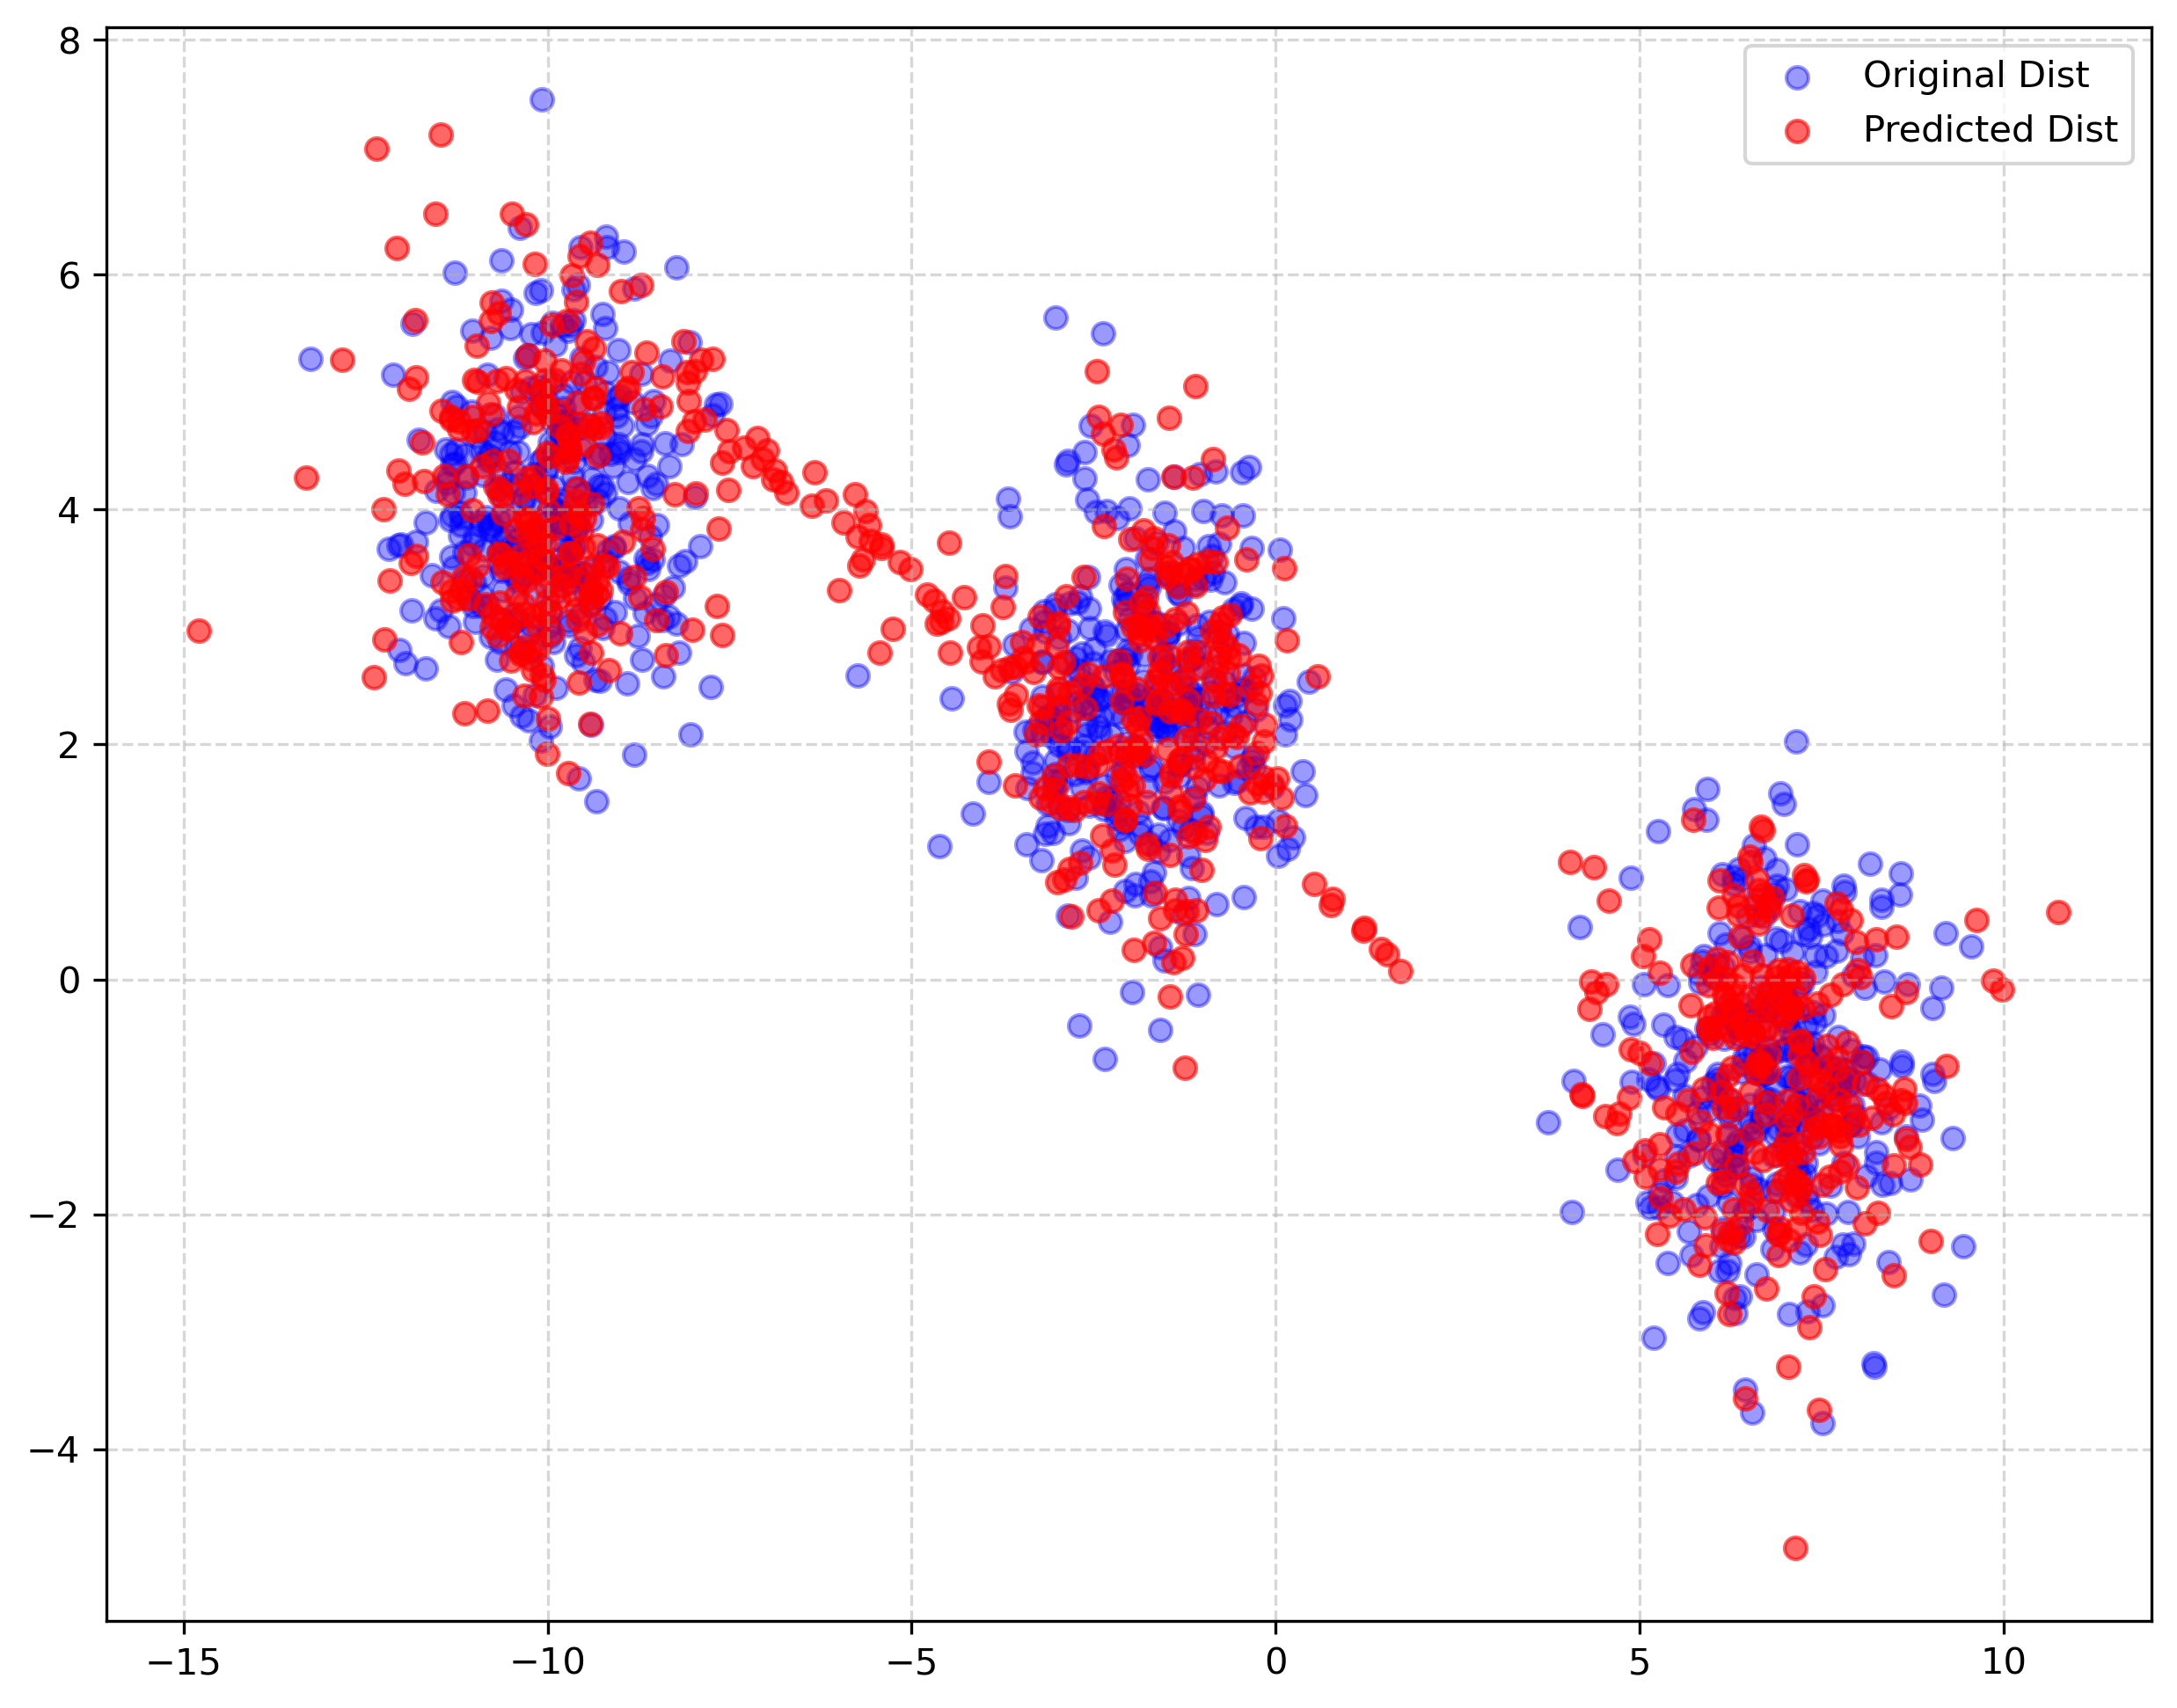

In [69]:
samples = optimized_flow.sample(800).detach().numpy()
plt.scatter(data[:, 0], data[:, 1], c='b', alpha=0.4, label='Original Dist')
plt.scatter(samples[:, 0, 0], samples[:, 0, 1], c='r', alpha=0.6, label='Predicted Dist')
plt.legend()
plt.grid(ls='--', alpha=0.5)
